In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style ("white")
import numpy as np

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

CONTROL = "#F95700FF"
TREATED = "#00A4CCFF"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

SOURCE_WT_FORMS = "Source: intervention forms"
SOURCE_REG = "Source: Facilities' registry book (Gov. of Mozambique)"

SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

cleaned_files_path = f"{ROOT}/anc/csv_cleaned"
CLEANED_DATA_PATH = f"{ROOT}/cleaned_data"
AUX = f"{ROOT}/aux"

anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230704.csv"
anc = pd.read_csv(anc_path)

img = "graphs"

def format_graph():
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

complier_df = pd.read_stata(f"{CLEANED_DATA_PATH}/complier.dta")
facility_characteristics = pd.read_stata(f"{AUX}/facility_characteristics.dta")

volume_baseline = pd.read_stata(f"{AUX}/facility_volume_baseline.dta")

complier_df = complier_df.merge(facility_characteristics, on=["facility_cod", "treatment"])


<ipython-input-7-b66242477725>:26: DtypeWarning: Columns (39,40,126) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


What worked and why?

Different definitions of compliance
    * hist percent of patients with scheduled time
    * hist percent of patients whose consultation was after 9:45

* percent scheduled by province
* after 10 by province
* percent scheduled by urban
* after 10 by urban


In [8]:
[c for c in anc if "cons" in c]

['consultation_duration',
 'consultation_reason',
 'consultation_time_float',
 'ANC_consults_averagenumber',
 'ART_monthly_average_consults']

In [34]:
[c for c in anc if 'sch' in c]

['time_scheduled_cleaned',
 'scheduled_mean_fac',
 'time_scheduled_hours',
 'scheduled_std']

<ipython-input-38-c23466ddaa58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  followup["after_10"] = 0


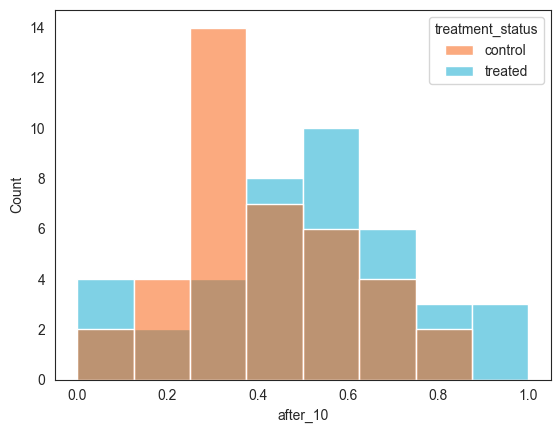

In [38]:
followup["after_10"] = 0
cons10 = followup.eval("time_entered >= 1000")
followup.loc[cons10, "after_10"] = 1

after10_df = (followup.query("day_of_week.isin([2,3,4])").
                groupby(["facility_cod", "treatment_status"])
                ["after_10"].mean().reset_index())

percent_sched = (anc.
                    groupby(["facility_cod", "treatment_status"])
                    ["scheduled_mean_fac"].mean().reset_index())

sns.histplot(after10_df, x="after_10", hue="treatment_status",
             palette=palette_anc,
             hue_order=order)
plt.show()

In [40]:
after10_df = after10_df.merge(percent_sched,
                              on=["facility_cod",
                                  "treatment_status"])

In [57]:
after10_t = after10_df.query("treatment_status == 'treated'")
np.corrcoef(after10_t["after_10"], after10_t["scheduled_mean_fac"])

array([[1.        , 0.43440222],
       [0.43440222, 1.        ]])

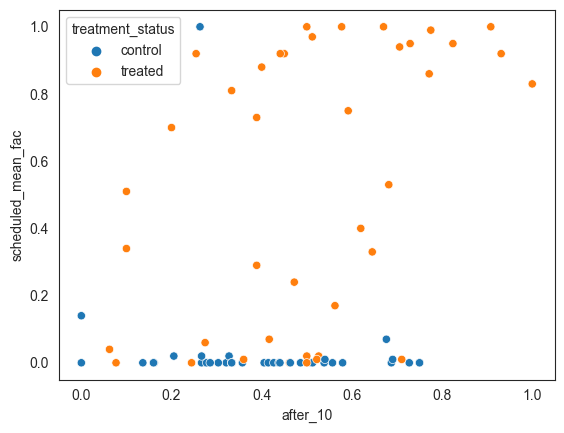

In [54]:
sns.scatterplot(after10_df,
                 x="after_10",
                 y="scheduled_mean_fac",
                 hue="treatment_status")
plt.show()


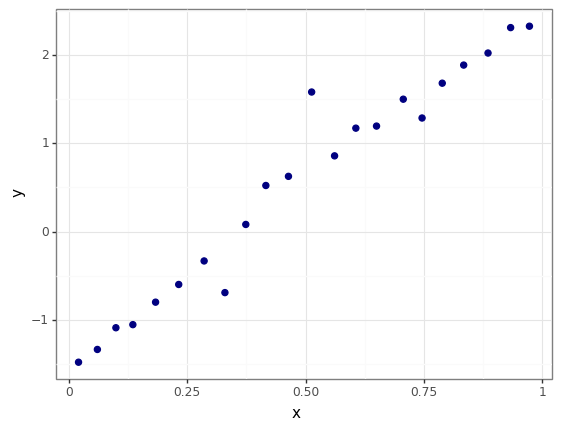

<ggplot: (682682947)>

In [61]:
import binsreg

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from plotnine import *
from binsreg import *

data = pd.read_csv("binsreg_sim.csv")

# Default syntax
est = binsreg('y', 'x', 'w', data=data)
est.bins_plot

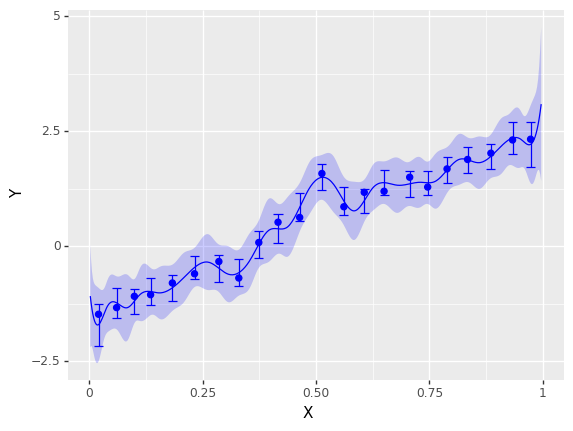

In [67]:
est = binsreg('y', 'x', 'w', data=data,line = (3,3), ci=(3,3), cb=(3,3), polyreg=4)

# Extract the plotting information
result = est.data_plot[0]

# Create the figure to plot
fig = ggplot() + labs(x='X',y ='Y')

# Add the dots
fig += geom_point(data=result.dots, mapping=aes(x='x', y='fit'), color="blue", size=2, shape='o')

# Add the line
fig += geom_line(data=result.line, mapping=aes(x='x', y='fit'), color="blue", size=0.5)

# Add the CI
fig += geom_errorbar(data=result.ci, mapping=aes(x='x', ymin='ci_l', ymax='ci_r'), color="blue", size=0.5, width = 0.02, linetype='solid')

# Add the CB
fig += geom_ribbon(data=result.cb, mapping=aes(x='x', ymin='cb_l', ymax='cb_r'), fill="blue", alpha=0.2)

# Add the polyreg
fig += geom_line(data=result.poly, mapping=aes(x='x', y='fit'), color="red", size=0.5)

# Display the plot
print(fig)

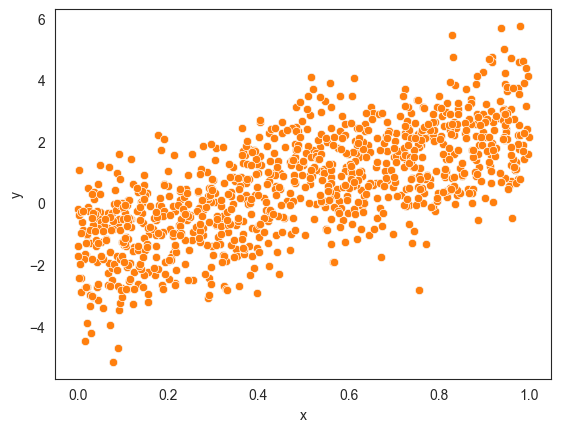

In [66]:
sns.scatterplot(data, x="x", y="y")
plt.show()